In [ ]:
# 리뷰 기반 미래 평점 예측 모델 (TensorFlow 기반)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
import matplotlib.pyplot as plt
from google.colab import files

Saving amazon-reviews-2023.parquet to amazon-reviews-2023.parquet


In [ ]:
# -------------------- 데이터 로딩 및 전처리 -------------------- #
uploaded = files.upload()
df = pd.read_parquet("amazon-reviews-2023.parquet")
from tensorflow.keras.models import load_model
model = load_model("my_checkpoint.keras")

In [7]:
#asin 기준으로 정렬 (timestamp 순서까지 보고 싶다면 timestamp도 포함)
df_sorted = df.sort_values(by=["asin", "timestamp"]).reset_index(drop=True)

# asin별 리뷰 개수 세기
asin_counts = df_sorted["asin"].value_counts()

# 리뷰 수가 10개 이상인 asin 목록 추출
valid_asins = asin_counts[asin_counts >= 10].index

# df_sorted에서 valid_asins인 행만 필터링
df_filtered = df_sorted[df_sorted["asin"].isin(valid_asins)].reset_index(drop=True)

#필터된 데이터에서 최종 확인
print("전체 리뷰 건수:", len(df_sorted))
print("리뷰 10개 이상인 상품만 남긴 뒤 리뷰 건수:", len(df_filtered))
print("남은 상품 개수:", df_filtered["asin"].nunique())

전체 리뷰 건수: 701528
리뷰 10개 이상인 상품만 남긴 뒤 리뷰 건수: 455218
남은 상품 개수: 13617


In [8]:
# 필터된 데이터(df_filtered)로 asin별 평균 평점 계산
avg_rating_filtered = (
    df_filtered
    .groupby("asin")["rating"]
    .mean()
    .reset_index(name="avg_rating")
)

# 결과 확인
print(avg_rating_filtered)

             asin  avg_rating
0      069267599X    4.780488
1      0816091846    4.642857
2      0985393300    4.900000
3      979077530X    4.296296
4      B000050AUD    4.185185
...           ...         ...
13612  B0BXT9PKCD    4.454545
13613  B0BY8RHDTH    4.636364
13614  B0BZ4JVW1T    4.520000
13615  B0C6GZ8GY5    4.400000
13616  B0CB2Y66H2    5.000000

[13617 rows x 2 columns]


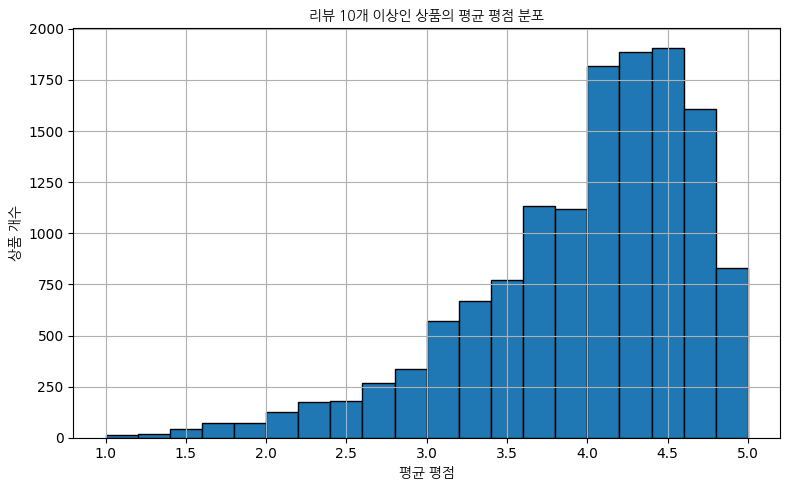

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(avg_rating_filtered['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('평균 평점',fontproperties=font_prop)
plt.ylabel('상품 개수',fontproperties=font_prop)
plt.title('리뷰 10개 이상인 상품의 평균 평점 분포', fontproperties = font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# timestamp 컬럼을 datetime 형식으로 변환
df_filtered["timestamp"] = pd.to_datetime(df_filtered["timestamp"])

# 각 상품(asin)별로 첫 번째 리뷰 날짜(최소 timestamp) 계산
first_review_dates = (
    df_filtered
    .groupby("asin")["timestamp"]
    .min()
    .reset_index(name="first_review_date")
)

# df_filtered에 첫 리뷰 날짜를 병합
df_with_first = pd.merge(
    df_filtered,
    first_review_dates,
    on="asin",
    how="left"
)

# 첫 리뷰일로부터 6개월 뒤 날짜 계산
#    pandas의 DateOffset을 사용하면 월 단위 덧셈이 가능합니다.
df_with_first["cutoff_date"] = df_with_first["first_review_date"] + pd.DateOffset(months=6)

# 초기 리뷰(첫 리뷰로부터 6개월 이내)를 필터링
initial_reviews = df_with_first[
    df_with_first["timestamp"] <= df_with_first["cutoff_date"]
].copy().reset_index(drop=True)


In [12]:
# 결과 확인
print("전체 필터된 리뷰 개수:", len(df_filtered))
print("초기 리뷰(첫 6개월)로 추출된 리뷰 개수:", len(initial_reviews))
print("초기 리뷰가 존재하는 상품 개수:", initial_reviews["asin"].nunique())

전체 필터된 리뷰 개수: 455218
초기 리뷰(첫 6개월)로 추출된 리뷰 개수: 157092
초기 리뷰가 존재하는 상품 개수: 13617


In [13]:
# 상품별 초기 리뷰 건수 확인 예시
init_counts = initial_reviews["asin"].value_counts().reset_index()
init_counts.columns = ["asin", "init_review_count"]
print(init_counts.head(10))

         asin  init_review_count
0  B012Q9NGE4                564
1  B08B1PR9C7                427
2  B01GS7QKQQ                368
3  B01195J43I                312
4  B08DKG8TJJ                308
5  B08L5KN7X4                301
6  B00R1TAN7I                291
7  B08RNQNFW1                291
8  B08BZNW9NK                286
9  B08CKCV9HD                268


In [14]:
#  상품별(initial_reviews 기준) "초기 리뷰 텍스트 리스트" 만들기
#   - initial_reviews: 첫 리뷰일자부터 6개월 이내 리뷰 데이터만 남음.

# 상품 하나(asin)당 초기 리뷰 댓글들(text)을 리스트로 묶기
grouped_initial = (
    initial_reviews
    .groupby("asin")["text"]
    .apply(list)
    .reset_index(name="initial_texts")
)

In [15]:
# avg_rating_filtered와 병합해서, 상품별 평균 평점을 가져오기
data = pd.merge(
    grouped_initial,
    avg_rating_filtered,   # asin, avg_rating
    on="asin",
    how="inner"
)

In [16]:
# (문자열이 아닌 값은 걸러내고 모두 str로 변환하여 합치는 함수 정의
def concat_texts(lst):
    # lst 안의 각 원소 x가 문자열(str) 타입인지 확인하고,
    # 공백만 있는 빈 문자열("")을 걸러내서 리스트로 남긴 뒤, ' '로 합침
    texts = []
    for x in lst:
        if isinstance(x, str):
            x = x.strip()
            if x:  # 빈 문자열이 아니면
                texts.append(x)
    return " ".join(texts)

# apply에 위 함수를 적용해서 text_concat 컬럼 생성
data["text_concat"] = data["initial_texts"].apply(concat_texts)

In [17]:
# 텍스트를 단어 인덱스로 변환하기 위해 Tokenizer 설정
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(data["text_concat"].values)

In [18]:
# 텍스트 → 정수 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(data["text_concat"].values)

=== 시퀀스 길이 분위수(Percentiles) ===
   percentile  length
0          50     213
1          75     482
2          90    1041
3          95    1608
4          99    3462


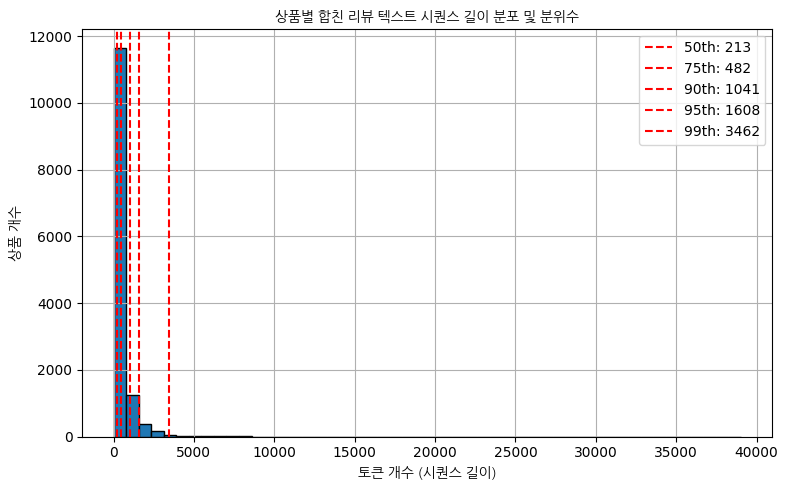

In [61]:
# 각 시퀀스 길이 계산
lengths = np.array([len(seq) for seq in sequences])

# 분위수(percentile) 계산 (예: 50, 75, 90, 95, 99 퍼센타일)
percentiles = [50, 75, 90, 95, 99]
p_values = np.percentile(lengths, percentiles)

# 결과를 보기 좋은 DataFrame으로 정리
percentile_df = pd.DataFrame({
    "percentile": percentiles,
    "length": p_values.astype(int)
})
print("=== 시퀀스 길이 분위수(Percentiles) ===")
print(percentile_df)

# 히스토그램으로 분포 시각화 (옵션)
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=50, edgecolor='black')
for p, val in zip(percentiles, p_values):
    plt.axvline(val, color='red', linestyle='--', label=f"{p}th: {int(val)}")
plt.xlabel("토큰 개수 (시퀀스 길이)",fontproperties=font_prop)
plt.ylabel("상품 개수",fontproperties=font_prop)
plt.title("상품별 합친 리뷰 텍스트 시퀀스 길이 분포 및 분위수",fontproperties=font_prop)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# 시퀀스 길이를 일정하게 맞추기 위해 패딩
MAX_LEN = 500
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

In [21]:
# 타깃(y) : 상품별 평균 평점 (float)
y = data["avg_rating"].values

# 학습/검증 데이터셋 분리 (예: 80% 학습, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Lambda
# LSTM 모델 정의
# ──────────────────────────────────────────────────────────────────────────────
EMBEDDING_DIM = 64  # 임베딩 차원

# (a) 입력 레이어: 시퀀스 길이 = MAX_LEN
input_layer = Input(shape=(MAX_LEN,), name="input_text")

# (b) 임베딩 레이어
x = Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, mask_zero=False, name="embedding")(input_layer)

# (c) LSTM 레이어
x = LSTM(64, return_sequences = True)(x)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences = True)(x)

# (d) Attention
attn_output = Attention(name="attention")([x, x])  # Self-attention
context_vector = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="context_vector")(attn_output)


output = Dense(1, activation= 'linear', name="output_rating")(context_vector)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 64)   │    640,000 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 500, 64)   │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 64)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 500, 32)   │     12,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 500, 32)   │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 32)        │          0 │ attention[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_rating       │ (None, 1)         │         33 │ context_vector[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 685,473 (2.61 MB)

 Trainable params: 685,473 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 2.4762 - mae: 1.0694 - val_loss: 0.4785 - val_mae: 0.5480
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.4930 - mae: 0.5480 - val_loss: 0.4738 - val_mae: 0.5366
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.4679 - mae: 0.5367 - val_loss: 0.4644 - val_mae: 0.5333
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.4739 - mae: 0.5375 - val_loss: 0.4414 - val_mae: 0.5181
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.3516 - mae: 0.4604 - val_loss: 0.2734 - val_mae: 0.4178
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.2385 - mae: 0.3817 - val_loss: 0.2459 - val_mae: 0.3805
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.1984 - mae: 0.3444 - val_loss: 0.2448 - val_mae: 0.3756
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.1686 - mae: 0.3188 - val_loss: 0.2614 - val_mae: 0.3877
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 

In [28]:
model.save('my_checkpoint.keras')


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


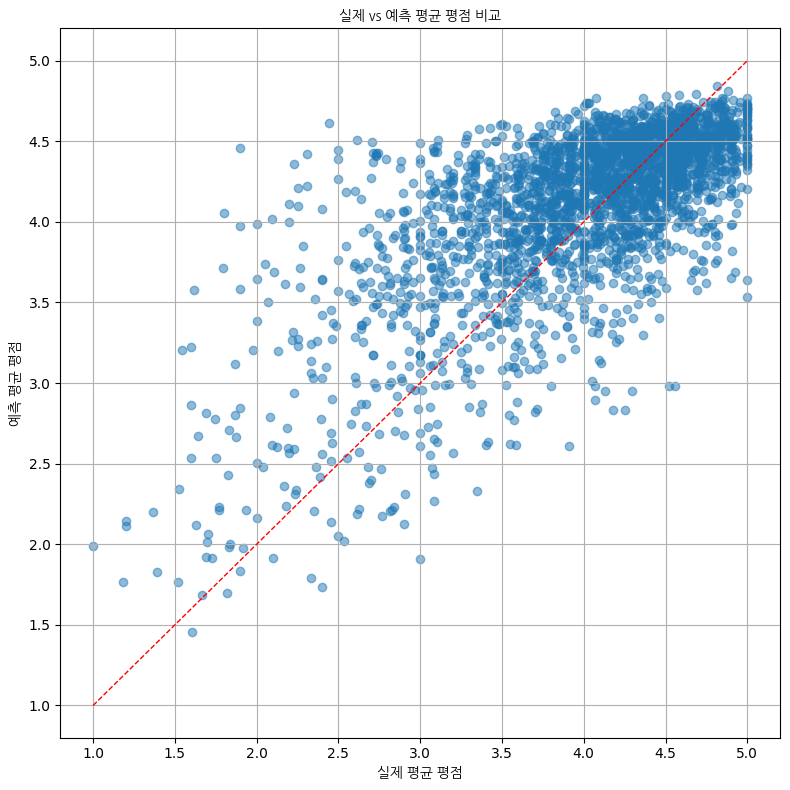

In [62]:
# 검증 세트에 대해 예측값 생성
#    - model: 학습 완료된 Keras LSTM 모델
#    - X_val: 검증 입력 시퀀스 (np.array)
#    - y_val: 검증 실제 평균 평점 (np.array)
# ──────────────────────────────────────────────────────────
y_pred = model.predict(X_val).flatten()

# ──────────────────────────────────────────────────────────
# 산점도: 실제 vs 예측
# ──────────────────────────────────────────────────────────
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5)
# y = x 기준선 추가 (완벽하게 예측하면 이 선 위에 점이 위치)
min_val = min(y_val.min(), y_pred.min())
max_val = max(y_val.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel("실제 평균 평점",fontproperties=font_prop)
plt.ylabel("예측 평균 평점",fontproperties=font_prop)
plt.title("실제 vs 예측 평균 평점 비교",fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

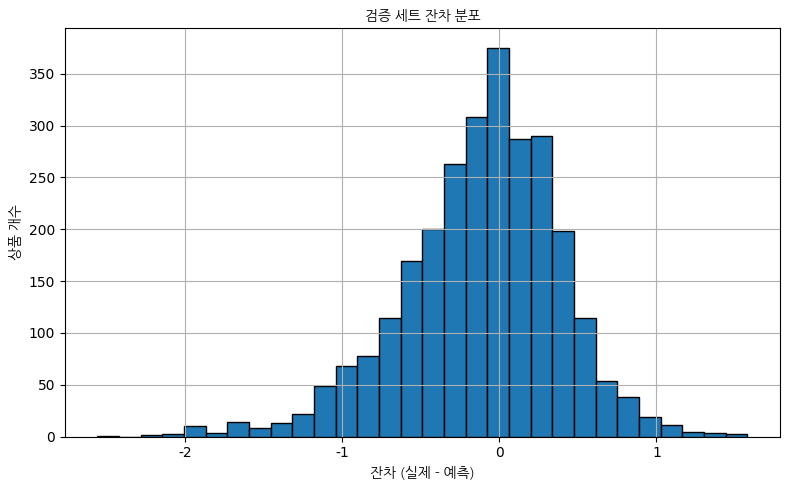

In [63]:
# 잔차(오차) 분포 히스토그램
residuals = y_val - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("잔차 (실제 - 예측)",fontproperties=font_prop)
plt.ylabel("상품 개수",fontproperties=font_prop)
plt.title("검증 세트 잔차 분포",fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# 검증 데이터에 대한 평균절대오차(MAE) 출력
# ──────────────────────────────────────────────────────────────────────────────
val_mae = model.evaluate(X_val, y_val, verbose=0)[1]
print(f">>> 검증 데이터 MAE: {val_mae:.4f}")

>>> 검증 데이터 MAE: 0.3893


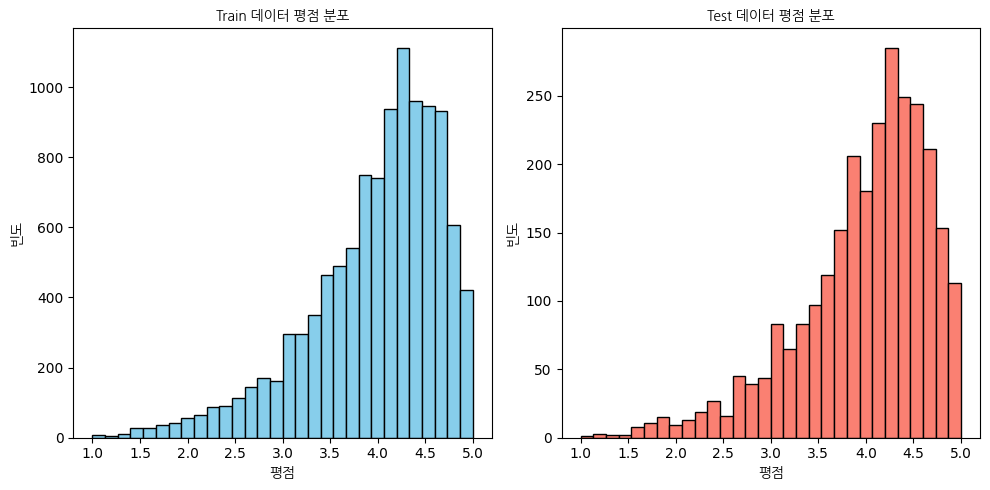

In [64]:
import matplotlib.pyplot as plt

# y_train, y_test는 실제 평점 값 (정답 레이블)
plt.figure(figsize=(10, 5))

# Train 분포
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.title('Train 데이터 평점 분포',fontproperties=font_prop)
plt.xlabel('평점',fontproperties=font_prop)
plt.ylabel('빈도',fontproperties=font_prop)

# Test 분포
plt.subplot(1, 2, 2)
plt.hist(y_val, bins=30, color='salmon', edgecolor='black')
plt.title('Test 데이터 평점 분포',fontproperties=font_prop)
plt.xlabel('평점',fontproperties=font_prop)
plt.ylabel('빈도',fontproperties=font_prop)

plt.tight_layout()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    # y_true가 0인 경우를 제외하고 계산
    nonzero_idx = y_true != 0
    return np.mean(
        np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])
    ) * 100

# MAPE 계산
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 11.19%


In [89]:
# 1. 전처리된 리뷰 시퀀스를 다시 원문 텍스트로 복원하려면 tokenizer가 필요
# tokenizer: Tokenizer 객체
# X_val: 시퀀스된 입력 데이터
# y_val: 실제 평점
# y_pred: 예측된 평점

# 시퀀스를 텍스트로 디코딩하는 함수
def decode_review(sequence, tokenizer):
    index_word = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([index_word.get(i, '') for i in sequence if i != 0])

# 2. 리뷰 텍스트, 실제값, 예측값 리스트 만들기
decoded_reviews = [decode_review(seq, tokenizer) for seq in X_val]
true_ratings = y_val
predicted_ratings = y_pred

# 3. 데이터프레임으로 묶기
import pandas as pd
df_result = pd.DataFrame({
    '리뷰 텍스트': decoded_reviews,
    '실제 평점': true_ratings,
    '예측 평점': predicted_ratings
})

In [93]:
pd.reset_option('display.max_colwidth')
# 예측 오차 계산
df_result['오차'] = abs(df_result['실제 평점'] - df_result['예측 평점'])

# 오차가 0.3 이하인 샘플만 추출
df_good = df_result[df_result['오차'] <= 0.3]

# 상위 5개 보기
df_good.head()

,리뷰 텍스트,실제 평점,예측 평점,오차
3,so i had this awesome vintage necklace after w...,3.818182,4.027779,0.209597
4,good <OOV> i must have gotten a lemon it took ...,4.264706,4.011184,0.253522
12,i am 2 weeks in and people have told me they'v...,4.000000,3.864112,0.135888
19,seems like a pretty good quality of hair very ...,4.111111,4.400019,0.288908
25,does the job pretty well and it leaves a quite...,4.428571,4.316956,0.111616
